In [ ]:
import pandas as pd

labels_df = pd.read_csv('/content/train_labels.csv')

In [ ]:
display(labels_df.head())

,image_id,soil_type
0,img_ed005410.jpg,Alluvial soil
1,img_0c5ecd2a.jpg,Alluvial soil
2,img_ed713bb5.jpg,Alluvial soil
3,img_12c58874.jpg,Alluvial soil
4,img_eff357af.jpg,Alluvial soil


In [ ]:
import os

# Construct full image file paths
image_dir = '/content/train_images/'
image_paths = [os.path.join(image_dir, img_id) for img_id in labels_df['image_id']]

# Extract corresponding labels
labels = labels_df['soil_type'].tolist()

# Create a list of (image_path, label) pairs
data = list(zip(image_paths, labels))

# Display the first few entries to verify
print("First 5 data entries:")
print(data[:5])

First 5 data entries:
[('/content/train_images/img_ed005410.jpg', 'Alluvial soil'), ('/content/train_images/img_0c5ecd2a.jpg', 'Alluvial soil'), ('/content/train_images/img_ed713bb5.jpg', 'Alluvial soil'), ('/content/train_images/img_12c58874.jpg', 'Alluvial soil'), ('/content/train_images/img_eff357af.jpg', 'Alluvial soil')]


In [ ]:
soil_type_distribution = labels_df['soil_type'].value_counts()
display(soil_type_distribution)

,count
soil_type,
Alluvial soil,528
Red soil,264
Black Soil,231
Clay soil,199


In [ ]:
missing_values = labels_df.isnull().sum()
display(missing_values)

,0
image_id,0
soil_type,0


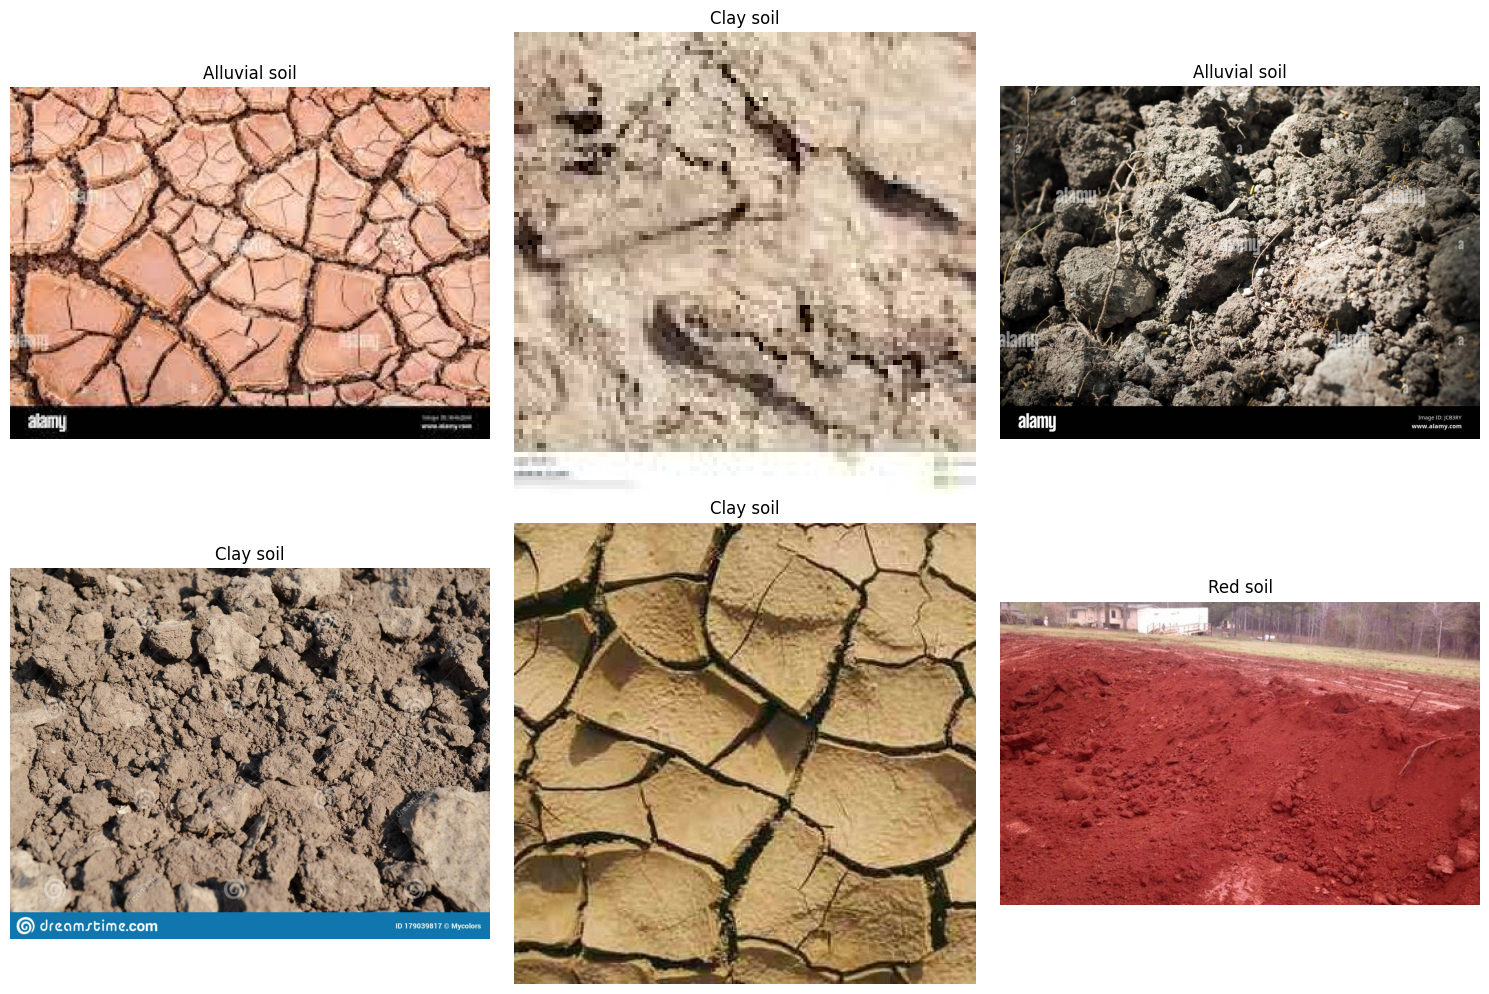

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

# Select a few random data entries
num_images_to_display = 6
selected_data = random.sample(data, num_images_to_display)

# Display the images and labels
plt.figure(figsize=(15, 10))
for i, (image_path, label) in enumerate(selected_data):
    plt.subplot(2, 3, i + 1)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from PIL import Image

# Define the target image size
target_size = (128, 128) # Example size, adjust as needed

preprocessed_images = []
processed_labels = []

for image_path, label in data:
    # Load the image
    img = Image.open(image_path)

    # Convert image to RGB (ensures 3 channels)
    img_rgb = img.convert("RGB")

    # Resize the image
    img_resized = img_rgb.resize(target_size)

    # Convert to NumPy array and normalize
    img_array = np.array(img_resized) / 255.0

    # Store the preprocessed image and label
    preprocessed_images.append(img_array)
    processed_labels.append(label)

# Convert lists to NumPy arrays for easier handling
preprocessed_images = np.array(preprocessed_images)
processed_labels = np.array(processed_labels)

print("Shape of preprocessed_images:", preprocessed_images.shape)
print("Shape of processed_labels:", processed_labels.shape)

Shape of preprocessed_images: (1222, 128, 128, 3)
Shape of processed_labels: (1222,)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    preprocessed_images,
    processed_labels,
    test_size=0.2,
    random_state=42
)

# Print the shapes of the resulting arrays to verify the split
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (977, 128, 128, 3)
Shape of X_val: (245, 128, 128, 3)
Shape of y_train: (977,)
Shape of y_val: (245,)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Instantiate ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Instantiate ImageDataGenerator for validation data without augmentation
val_datagen = ImageDataGenerator()

# Define batch size
batch_size = 32

# Create data generator for training data
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)

# Create data generator for validation data
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)

print("Training data generator created.")
print("Validation data generator created.")

Training data generator created.
Validation data generator created.


In [ ]:
from sklearn.utils import class_weight
import numpy as np
import pandas as pd # Import pandas

# Get unique classes and their counts from the training labels
classes = np.unique(y_train)

# Calculate class weights using compute_class_weight directly on y_train
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=classes,
    y=y_train
)

# Create a dictionary of class weights
class_weights_dict = dict(zip(range(len(classes)), class_weights))

print("Calculated Class Weights:")
print(class_weights_dict)

Calculated Class Weights:
{0: np.float64(0.5787914691943128), 1: np.float64(1.2721354166666667), 2: np.float64(1.6175496688741722), 3: np.float64(1.1521226415094339)}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Get the number of unique classes from the training labels
num_classes = len(np.unique(processed_labels)) # Use processed_labels which contains all labels

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Display the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# from tensorflow.keras.metrics import accuracy # Removed the incorrect import

# Compile the model with a slightly lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), # Adjusted learning rate
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

print("Model compiled successfully with adjusted learning rate.")

Model compiled successfully with adjusted learning rate.


In [ ]:
# Define the number of epochs for training
epochs = 75 # Increased the number of epochs

# Train the model using the data generators and class weights
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    class_weight=class_weights_dict
)

print("Model training completed with increased epochs.")

Epoch 1/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9569 - loss: 0.1164 - val_accuracy: 0.9347 - val_loss: 0.3439
Epoch 2/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9771 - loss: 0.0479 - val_accuracy: 0.9020 - val_loss: 0.4308
Epoch 3/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9423 - loss: 0.1346 - val_accuracy: 0.9347 - val_loss: 0.3257
Epoch 4/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9740 - loss: 0.0727 - val_accuracy: 0.9347 - val_loss: 0.3550
Epoch 5/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9797 - loss: 0.0409 - val_accuracy: 0.9306 - val_loss: 0.4314
Epoch 6/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9778 - loss: 0.0629 - val_accuracy: 0.9347 - val_loss: 0.3779
Epoch 7/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9625 - loss: 0.0752 - val_accuracy: 0.9306 - val_loss: 0.4142
Epoch 8/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9777 - loss: 0.0383 - val_accuracy: 0.9347 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9819 - loss: 0.0412 - val_accuracy: 0.9306 - val_loss: 0.4715
Epoch 11/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9854 - loss: 0.0341 - val_accuracy: 0.9102 - val_loss: 0.5071
Epoch 12/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9738 - loss: 0.0620 - val_accuracy: 0.9061 - val_loss: 0.3876
Epoch 13/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9693 - loss: 0.0578 - val_accuracy: 0.9347 - val_loss: 0.4915
Epoch 14/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9775 - loss: 0.0380 - val_accuracy: 0.9347 - val_loss: 0.5015
Epoch 15/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9851 - loss: 0.0294 - val_accuracy: 0.9347 - val_loss: 0.5484
Epoch 16/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9721 - loss: 0.0589 - val_accuracy: 0.8939 - val_loss: 0.5062
Epoch 17/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9571 - loss: 0.0726 - val_accuracy: 0.9347 - val_loss: 0.4

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step

Validation Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.95      0.94      0.95       106
   Black Soil       0.90      0.95      0.93        39
    Clay soil       0.92      0.92      0.92        48
     Red soil       1.00      0.98      0.99        52

     accuracy                           0.95       245
    macro avg       0.94      0.95      0.94       245
 weighted avg       0.95      0.95      0.95       245

Validation Weighted F1 Score: 0.9471


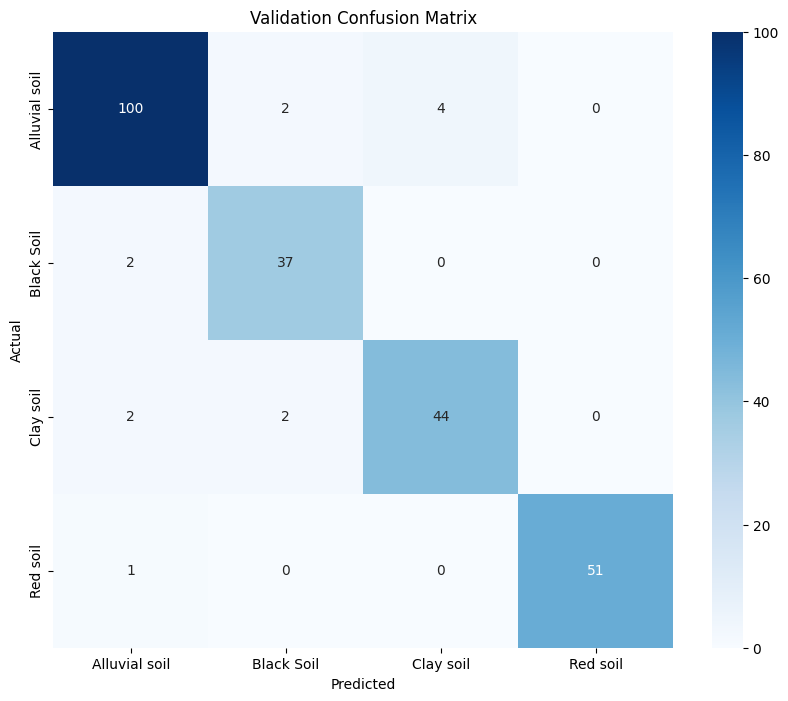

In [ ]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions on validation set
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Classification Report:")
print(classification_report(y_val_encoded, y_pred_val_classes, target_names=label_encoder.classes_))

val_f1 = f1_score(y_val_encoded, y_pred_val_classes, average='weighted')
print(f"Validation Weighted F1 Score: {val_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val_encoded, y_pred_val_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
test_ids_df = pd.read_csv('/content/test_ids.csv')
display(test_ids_df.head())

,image_id
0,img_cdf80d6f.jpeg
1,img_c0142a80.jpg
2,img_91168fb0.jpg
3,img_9822190f.jpg
4,img_e5fc436c.jpeg


In [ ]:
# Define the directory where the test images are located
test_image_dir = '/content/test_images/'

# Extract the image IDs from the test_ids_df DataFrame
test_image_ids = test_ids_df['image_id']

# Create a list of full image paths
test_image_paths = [os.path.join(test_image_dir, img_id) for img_id in test_image_ids]

# Print the first few elements to verify
print("First 5 test image paths:")
print(test_image_paths[:5])

First 5 test image paths:
['/content/test_images/img_cdf80d6f.jpeg', '/content/test_images/img_c0142a80.jpg', '/content/test_images/img_91168fb0.jpg', '/content/test_images/img_9822190f.jpg', '/content/test_images/img_e5fc436c.jpeg']


In [ ]:
import numpy as np
from PIL import Image

# Initialize an empty list for preprocessed test images
preprocessed_test_images = []

# Iterate through each image_path in the test_image_paths list
for image_path in test_image_paths:
    # Open the image
    img = Image.open(image_path)

    # Convert image to RGB (ensures 3 channels)
    img_rgb = img.convert("RGB")

    # Resize the image
    img_resized = img_rgb.resize(target_size)

    # Convert to NumPy array and normalize
    img_array = np.array(img_resized) / 255.0

    # Append the preprocessed image NumPy array to the list
    preprocessed_test_images.append(img_array)

# Convert the list to a NumPy array
preprocessed_test_images = np.array(preprocessed_test_images)

# Print the shape of the preprocessed test images array
print("Shape of preprocessed_test_images:", preprocessed_test_images.shape)

Shape of preprocessed_test_images: (341, 128, 128, 3)


In [ ]:
# Use the trained model to predict the soil type for each test image
test_predictions_probs = model.predict(preprocessed_test_images)

# Get the predicted class index for each test image
test_predicted_classes_encoded = np.argmax(test_predictions_probs, axis=1)

print("Predicted class indices for test images obtained.")

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step
Predicted class indices for test images obtained.


In [ ]:
# Convert the predicted class indices back to original labels
test_predicted_labels = label_encoder.inverse_transform(test_predicted_classes_encoded)

# Print the first few predicted labels to verify
print("First 5 predicted soil types for test images:")
print(test_predicted_labels[:5])

First 5 predicted soil types for test images:
['Alluvial soil' 'Alluvial soil' 'Alluvial soil' 'Alluvial soil'
 'Alluvial soil']


In [ ]:
# Create a DataFrame with test image IDs and predicted labels
submission_df = pd.DataFrame({
    'image_id': test_image_ids,
    'soil_type': test_predicted_labels
})

# Display the head of the DataFrame
display(submission_df.head())

,image_id,soil_type
0,img_cdf80d6f.jpeg,Alluvial soil
1,img_c0142a80.jpg,Alluvial soil
2,img_91168fb0.jpg,Alluvial soil
3,img_9822190f.jpg,Alluvial soil
4,img_e5fc436c.jpeg,Alluvial soil


In [ ]:
# Define the filename for the submission CSV file
submission_filename = f'submission_f1_{val_f1:.4f}.csv'

# Save the submission_df DataFrame to a CSV file
submission_df.to_csv(submission_filename, index=False)

# Print a confirmation message
print(f"Submission file saved as: {submission_filename}")

Submission file saved as: submission_f1_0.9471.csv
